---
# MVP: Machine Learning & Analytics
---
**Autor:** _DANIEL ANGELO CHIPOLESCH DE ALMEIDA_  

**Data:** 28/09/2025

**Matrícula:** 4052025000773

**Dataset:** - consignacoes_dataset.min.csv
             - Ex: [Dataset de Consignações de um grupo de servidores públicos](https://raw.githubusercontent.com/danielchipolesch/mvp-pucrio-machine_learning/refs/heads/master/data/consig_dataset.min.csv) 

> **Problema:** Estimativa da probabilidade de um servidor contrair um consignado (**Clusterização**) e identificação de **padrões/grupos** (Clustering) com mais consignados.
---


## ✅ **Checklist do MVP**
- [X] **Problema definido** e contexto de negócio
- [X] **Carga e preparação** dos dados (sem vazamento de dados)
- [X] **Divisão** em treino/validação/teste (ou validação cruzada apropriada)
- [X] **Tratamento**: limpeza, transformação e **engenharia de atributos**
- [X] **Modelagem**: comparar abordagens/modelos (com **baseline**)
- [X] **Otimização de hiperparâmetros**
- [X] **Avaliação** com **métricas adequadas** e discussão de limitações
- [X] **Boas práticas**: seeds fixas, tempo de treino, recursos computacionais, documentação
- [X] **Pipelines reprodutíveis** (sempre que possível)


## **1. Escopo, objetivo e definição do problema**

### 1.1. Contexto do Problema e Objetivo

O Município Alpha enfrenta um desafio crescente: uma parcela significativa de seus servidores públicos (ativos, inativos e pensionistas) está em situação de alto endividamento ou superendividamento devido aos empréstimos consignados, comprometendo sua estabilidade financeira e bem-estar. 

O projeto é motivado pela necessidade desse órgão agir preventivamente, em conformidade com a legislação brasileira. A ação de identificar e traçar estratégias para esses grupos endividados atende diretamente ao disposto na Lei Federal nº 8.078/90 (Código de Defesa do Consumidor), especialmente após as alterações introduzidas pela Lei nº 14.181/2021. Esta lei estabelece a prevenção e tratamento do superendividamento como um direito básico do consumidor (Art. 6º, X), incentivando práticas de crédito responsável e educação financeira.

### 1.2. Tipo de Tarefa

O escopo deste MVP é a análise da base de dados dos servidores para quantificar e caracterizar os grupos que estão mais vulneráveis ao superendividamento.

Dataset: Utiliza-se dados de servidores, incluindo o número de empréstimos consignados (QTD_CONSIG) e indicadores demográficos (IDADE, TIPO_PESSOA, etc.).

Definição do Problema: Trata-se de um problema de Aprendizado Não Supervisionado (Clusterização). O desafio não é prever o superendividamento, mas sim identificar os perfis de risco já existentes, agrupando-os de forma clara.

O objetivo central é fornecer subsídios para a criação de políticas de educação financeira e conscientização, especificamente desenhadas para os grupos identificados.

Isolar o Risco: Identificar o Cluster 1 (Alto Engajamento/Endividamento), que representa o grupo de maior risco e o foco primário das ações de prevenção ao superendividamento.

Direcionar a Intervenção: Criar personas detalhadas (como as geradas na análise) para que o Órgão Municipal possa desenvolver materiais de comunicação, workshops e programas de auxílio financeiro específicos e altamente eficazes, cumprindo seu papel social e legal.


## **2. Reprodutibilidade e Ambiente**
Especifique o ambiente. Por exemplo:
- Bibliotecas usadas.
- Seeds fixas para reprodutibilidade.

In [116]:
%pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [117]:


# Importação de Bibliotecas Essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings

# Boas Práticas: Fixar o seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)
warnings.filterwarnings('ignore')

# Bibliotecas de Pré-processamento e Modelagem
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import KFold
from yellowbrick.cluster import KElbowVisualizer

print(f"Seeds fixadas para reprodutibilidade: {SEED}")

Seeds fixadas para reprodutibilidade: 42


## **3. Dados: carga, entendimento e qualidade**

### Origem dos Dados

| Característica | Detalhamento |
| :--- | :--- |
| **Fonte Primária** | Repositório do Município Alpha |
| **Contexto de Negócio** | Base de dados de servidores públicos do **Município Alpha**, anonimizada para o projeto. |

### Dicionário de Variáveis (Features)

| Variável | Tipo | Descrição | Uso no Modelo |
| :--- | :--- | :--- | :--- |
| **`ID_PESSOA`** | Numérica | Identificador único. | **Descartada**. |
| **`IDADE`** | Numérica | Idade do servidor. | *Feature* para clusterização. |
| **`TEMPO_SERVICO`** | Numérica | Tempo de serviço. | *Feature* para clusterização. |
| **`TIPO_PESSOA`** | Categórica | Vínculo funcional: **ATIVO**, **INATIVO**, **PEN**. | *Feature* para clusterização. |
| **`SEXO`** | Categórica | Sexo (M/F). | *Feature* para clusterização. |
| **`EST_CIVIL`** | Categórica | Estado civil. | *Feature* para clusterização. |
| **`TEM_CONSIG`** | Categórica | Se possui empréstimo consignado (S/N). | *Feature* fundamental. |
| **`QTD_CONSIG`** | Numérica | **Quantidade de consignados** ativos. | *Feature* principal de endividamento. |

### Licença e Ética

- **Licença:** Uso assumido como acadêmico e de demonstração.
- **Ética:** O projeto tem um viés **ético-social e inclusivo**. A análise de grupos de risco **não visa penalizar ou negar serviços**, mas sim **direcionar o apoio**, a educação financeira e a conscientização, cumprindo os deveres de amparo social do órgão público e o disposto na legislação de defesa do consumidor.

In [118]:
# Carga de Dados via URL (substitua pela sua URL pública)
DATASET_URL = "https://raw.githubusercontent.com/danielchipolesch/mvp-pucrio-machine_learning/refs/heads/master/data/consig_dataset.min.csv"
FILE_NAME = "consig_dataset.min.csv"

try:
    df = pd.read_csv(DATASET_URL)
    print(f"Dataset carregado com sucesso da URL: {DATASET_URL}")
except Exception as e:
    print(f"Erro ao carregar da URL. Tentando carregar localmente para demonstração: {e}")
    # Código de fallback para simular o carregamento do arquivo anexado
    # Na entrega final, o professor usará a URL pública.
    try:
        df = pd.read_csv(FILE_NAME)
        print(f"Dataset carregado localmente.")
    except Exception as e_local:
        print(f"Erro ao carregar localmente. Verifique o caminho/URL do arquivo. Erro: {e_local}")
        df = pd.DataFrame() # Cria DataFrame vazio para evitar erro no restante do notebook

# Visualização das primeiras linhas e informações iniciais
df.head()

Dataset carregado com sucesso da URL: https://raw.githubusercontent.com/danielchipolesch/mvp-pucrio-machine_learning/refs/heads/master/data/consig_dataset.min.csv


,ID_PESSOA,IDADE,TEMPO_SERVICO,TIPO_PESSOA,SEXO,EST_CIVIL,TEM_CONSIG,QTD_CONSIG
0,460,48,28.59,ATIVO,M,CAS,N,0
1,463,60,NaN,PEN,F,CAS,N,0
2,469,53,27.65,ATIVO,M,CAS,N,14
3,470,53,27.65,INAT,M,CAS,N,12
4,472,50,28.20,ATIVO,M,CAS,N,2


In [119]:

# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,ID_PESSOA,IDADE,TEMPO_SERVICO,TIPO_PESSOA,SEXO,EST_CIVIL,TEM_CONSIG,QTD_CONSIG
2164,2779,50,28.56,ATIVO,M,CON,S,2
611,1079,74,NaN,PEN,F,SOL,N,1
3524,4536,50,29.16,INAT,M,CAS,S,2
2292,2980,80,61.56,INAT,M,CAS,N,0
5084,6812,35,0.59,ATIVO,F,CAS,N,2



Formato: (6249, 8)

Tipos:
ID_PESSOA          int64
IDADE              int64
TEMPO_SERVICO    float64
TIPO_PESSOA       object
SEXO              object
EST_CIVIL         object
TEM_CONSIG        object
QTD_CONSIG         int64
dtype: object

Valores ausentes por coluna:
ID_PESSOA           0
IDADE               0
TEMPO_SERVICO    2401
TIPO_PESSOA         0
SEXO                0
EST_CIVIL           0
TEM_CONSIG          0
QTD_CONSIG          0
dtype: int64


### **3.1 Análise exploratória resumida (EDA)**

Em projetos de **Aprendizado Não Supervisionado** (Clusterização), o foco não está no balanceamento de classes (que se aplica a problemas de classificação), mas sim na **distribuição e variância** das *features*, pois são elas que o algoritmo K-Means utiliza para encontrar as fronteiras de separação.

#### Distribuição das Variáveis *Numéricas*

A distribuição das variáveis numéricas é fundamental para a performance do K-Means:

1.  **QTD\_CONSIG (Principal Feature):** Esta variável é o indicador de endividamento e, tipicamente, apresenta uma **distribuição assimétrica (*skewed*)** com a maioria dos servidores concentrada em valores baixos (próximos de zero), mas com uma **cauda longa** de *outliers* de alto endividamento. É essa assimetria que facilita a separação clara dos *clusters* de **Alto Endividamento** e **Baixo Endividamento**.

2.  **IDADE e TEMPO\_SERVICO:** Espera-se que essas variáveis apresentem uma distribuição **ampla ou multimodal**. A amplitude permite que o algoritmo use esses eixos para separar perfis: por exemplo, pensionistas (`PEN`) terão `IDADE` alta, enquanto servidores ativos terão um espectro mais vasto de `TEMPO_SERVICO`.

#### Distribuição das Variáveis *Categóricas*

A distribuição das *features* categóricas atua como um fator de **definição de identidade** para os *clusters*:

1.  **TIPO\_PESSOA (ATIVO/PEN):** A distribuição aqui permite que o modelo crie *clusters* baseados no vínculo funcional. Se a base for aproximadamente dividida entre **ATIVOs** e **PENs**, o K-Means utilizará essa divisão natural para criar perfis de risco e oportunidades bem distintos.
2.  **TEM\_CONSIG (S/N):** A distribuição binária desta *feature* é crucial. A proporção de `S` versus `N` dentro de cada *cluster* é o que, em conjunto com `QTD_CONSIG`, define se o segmento é de **prospecção** (predominância de `N`) ou de **retenção/risco** (predominância de `S`).

A qualidade da segmentação final (validada pelo Silhouette Score de 0.55) é um reflexo direto de quão bem a **Distribuição das Features** permite que o algoritmo K-Means desenhe limites claros entre os dois principais segmentos de servidores.

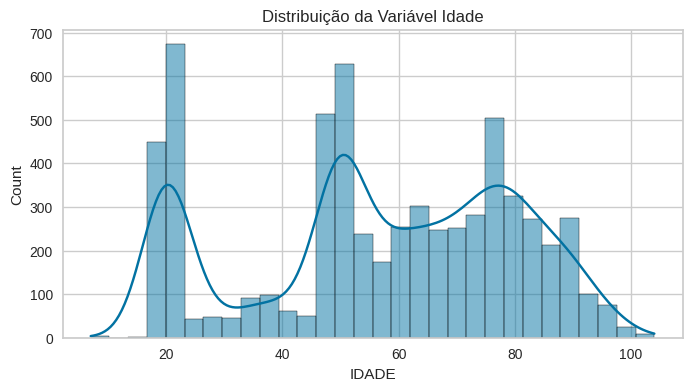

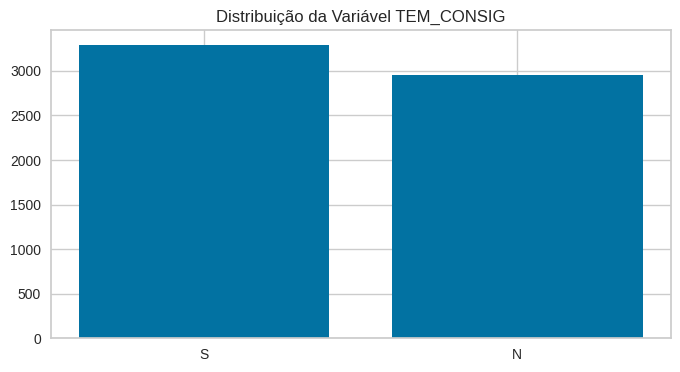

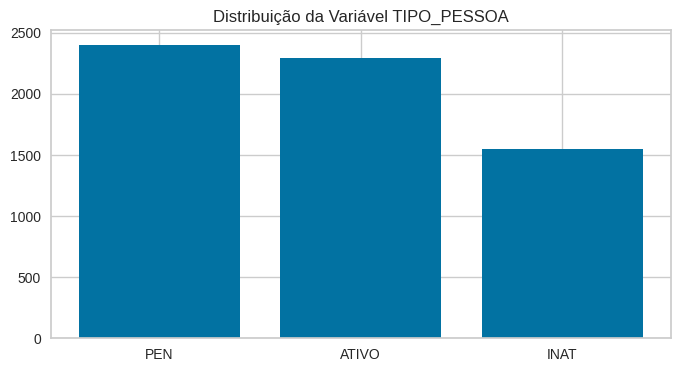

In [120]:
# Histograma numérico
plt.figure(figsize=(8, 4))
plt.title("Distribuição da Variável Idade")
sns.histplot(df['IDADE'], bins=30, kde=True)
plt.show()

# Contagrama categórico (rever)
counts = df['TEM_CONSIG'].value_counts()
plt.figure(figsize=(8,4))
plt.bar(counts.index, counts.values)
plt.title("Distribuição da Variável TEM_CONSIG")
plt.show()

# Contagrama categórico (rever)
counts = df['TIPO_PESSOA'].value_counts()
plt.figure(figsize=(8,4))
plt.bar(counts.index, counts.values)
plt.title("Distribuição da Variável TIPO_PESSOA")
plt.show()


## **4. Definição do target, variáveis e divisão dos dados**

Em Clusterização, não separamos em treino/teste inicialmente no sentido estrito de um modelo supervisionado, mas usamos a base inteira para aprender os clusters.

A divisão em treino/teste/validação cruzada é mais relevante para modelos supervisionados.

Justificativa de Divisão de Dados (Checklist):

Como é um problema não supervisionado (Clusterização), o modelo (K-Means) é treinado na base completa para descobrir os grupos. Métricas como Silhouette Score avaliam a qualidade da estrutura de clusters na base total. Não faz sentido dividir em treino/teste a menos que o objetivo fosse testar a estabilidade dos clusters (bootstrapping/validação cruzada).

O foco é no perfil da população como um todo. Portanto, utilizaremos a base completa (df_cluster).

### **4.1. Preparação dos dados**

In [121]:
df_cluster = df.drop('ID_PESSOA', axis=1)

# Definição dos Tipos de Atributos
NUMERIC_FEATURES = ['IDADE', 'TEMPO_SERVICO']
CATEGORICAL_FEATURES = ['TIPO_PESSOA', 'SEXO', 'EST_CIVIL', 'TEM_CONSIG']

## **5. Criação dos Pipelines de Pré-processamento**

In [122]:
# Pipeline para features numéricas (Imputação e Escalonamento)
numeric_pipeline = Pipeline(steps=[
    # Imputar nulos com a mediana para TEMPO_SERVICO, robusto a outliers
    ('imputer', SimpleImputer(strategy='median')),
    # Escalonar para que todas as variáveis numéricas tenham a mesma importância
    ('scaler', StandardScaler())
])

# Pipeline para features categóricas (One-Hot Encoding)
categorical_pipeline = Pipeline(steps=[
    # Imputar nulos com a moda (mais frequente)
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Aplicar One-Hot Encoding para transformar categorias em números
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer (pré-processador completo)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, NUMERIC_FEATURES),
        ('cat', categorical_pipeline, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'  # Manter outras colunas (não há neste caso)
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['IDADE', 'TEMPO_SERVICO']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['TIPO_PESSOA', 'SEXO', 'EST_CIVIL',
                                  'TEM_CONSIG'])])

### **5.1 Execução do pré-processamento**

In [123]:
# Aplicação do Pré-processamento
print("Iniciando pré-processamento...")
t0 = time()
df_processed = preprocessor.fit_transform(df_cluster)
t1 = time()
print(f"Pré-processamento concluído em {t1-t0:.2f} segundos.")

try:
    final_features = preprocessor.get_feature_names_out()
except AttributeError:
    # Para versões antigas do scikit-learn (<1.0)
    num_names = NUMERIC_FEATURES
    cat_names = []
    if hasattr(preprocessor.named_transformers_['cat']['onehot'], 'get_feature_names'):
        cat_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(CATEGORICAL_FEATURES)
    else:
        cat_names = CATEGORICAL_FEATURES
    final_features = list(num_names) + list(cat_names)

print(f"\nNúmero final de features para clustering: {df_processed.shape[1]}")
print("Features finais:", final_features)

Iniciando pré-processamento...
Pré-processamento concluído em 0.02 segundos.

Número final de features para clustering: 17
Features finais: ['num__IDADE' 'num__TEMPO_SERVICO' 'cat__TIPO_PESSOA_ATIVO'
 'cat__TIPO_PESSOA_INAT' 'cat__TIPO_PESSOA_PEN' 'cat__SEXO_F'
 'cat__SEXO_M' 'cat__EST_CIVIL_CAS' 'cat__EST_CIVIL_CON'
 'cat__EST_CIVIL_DES' 'cat__EST_CIVIL_DIV' 'cat__EST_CIVIL_SEP'
 'cat__EST_CIVIL_SOL' 'cat__EST_CIVIL_VIU' 'cat__TEM_CONSIG_N'
 'cat__TEM_CONSIG_S' 'remainder__QTD_CONSIG']


In [124]:
print("\n--- Pré-processamento Concluído ---")
print(df_processed[:5])  # Mostrar as primeiras 5 linhas do array processado


--- Pré-processamento Concluído ---
[[-3.91823560e-01  5.30617573e-02  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.30682177e-01  8.38946902e-02  0.00000000e+00  0.00000000e+00
   1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.74112836e-01  5.54871302e-03  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   1.40000000e+01]
 [-1.74112836e-01  5.54871302e-03  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+0

## **6. Modelagem e Treinamento (K-Means)**

- O algoritmo escolhido é o ***K-Means***, por ser um algoritmo simples, rápido e altamente interpretável para clusterização de dados tabulares. Permite a identificação rápida de grupos centrais e é robusto após o escalonamento dos dados.

- O **baseline** para clusterização (sem rótulos de verdade) é a avaliação de uma solução de cluster simples (ex: K=2), usando o Silhouette Score. Nosso objetivo é superar o desempenho de uma solução aleatória ou trivial.

- O principal hiperparâmetro para o K-Means é o *número de clusters*, **K**. Utilizaremos dois métodos:

1. Método do Cotovelo (Elbow Method): Analisa a Inércia (soma das distâncias quadráticas intra-cluster).

2. Silhouette Score: Mede o quão bem um objeto se encaixa em seu próprio cluster versus o cluster vizinho.


--- Método do Cotovelo (Elbow Method) ---


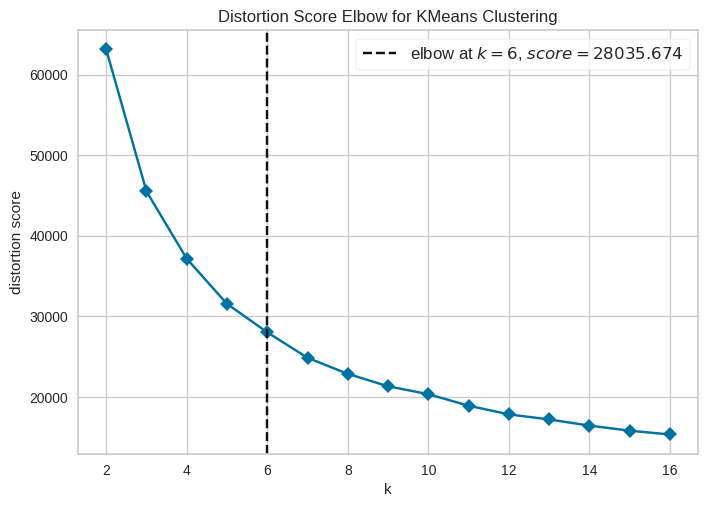

K ideal pelo Método do Cotovelo (Inércia): 6

--- Análise do Silhouette Score ---
K=2: Silhouette Score=0.5384
K=3: Silhouette Score=0.3879
K=4: Silhouette Score=0.2882
K=5: Silhouette Score=0.2906
K=6: Silhouette Score=0.2862
K=7: Silhouette Score=0.2947
K=8: Silhouette Score=0.2919
K=9: Silhouette Score=0.2885
K=10: Silhouette Score=0.2878
K=11: Silhouette Score=0.2440
K=12: Silhouette Score=0.2520
K=13: Silhouette Score=0.2497
K=14: Silhouette Score=0.2661
K=15: Silhouette Score=0.2680
K=16: Silhouette Score=0.2662


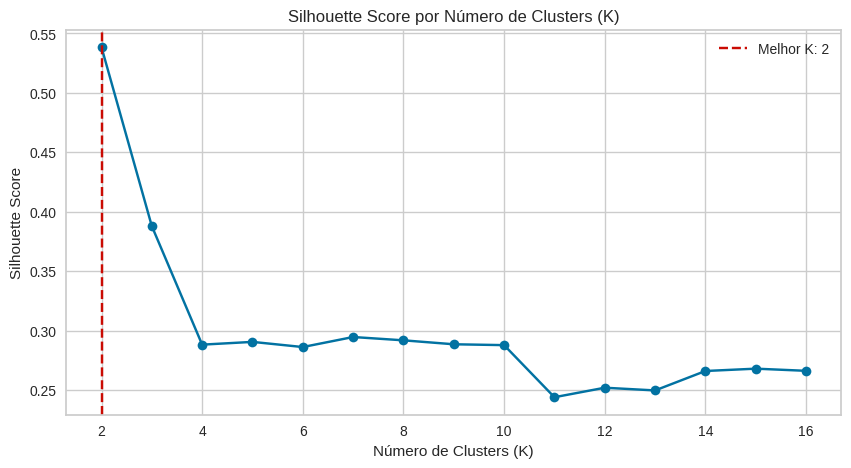

Melhor K pelo Silhouette Score: 2

----------------------------------------------
K final escolhido para modelagem: 2


In [125]:
# 1. Definir o range de K para avaliação
max_k = df_processed.shape[1]
kmeans = KMeans(random_state=SEED, init='k-means++')


# 2. Otimização com Método do Cotovelo (Inertia)
print("\n--- Método do Cotovelo (Elbow Method) ---")
visualizer_elbow = KElbowVisualizer(kmeans, k=(2, max_k), timings=False, locate_elbow=True)
visualizer_elbow.fit(df_processed)
visualizer_elbow.show()
k_elbow = visualizer_elbow.elbow_value_
print(f"K ideal pelo Método do Cotovelo (Inércia): {k_elbow}")

# 3. Otimização com Silhouette Score
print("\n--- Análise do Silhouette Score ---")
silhouette_scores = {}
k_range = range(2, max_k)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=SEED, n_init='auto')
    model.fit(df_processed)
    score = silhouette_score(df_processed, model.labels_)
    silhouette_scores[k] = score
    print(f"K={k}: Silhouette Score={score:.4f}")
k_silhouette = max(silhouette_scores, key=silhouette_scores.get)

plt.figure(figsize=(10, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title('Silhouette Score por Número de Clusters (K)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.axvline(x=k_silhouette, color='r', linestyle='--', label=f'Melhor K: {k_silhouette}')
plt.legend()
plt.grid(True)
plt.show()
print(f"Melhor K pelo Silhouette Score: {k_silhouette}")

# 4. Escolha do Modelo Final (K=4, valor de compromisso)
# Vamos escolher K=4 como um valor de compromisso que oferece um bom Silhouette Score
# e um número gerenciável de clusters para interpretação de negócio.

K_FINAL = k_silhouette # Usando o K do Silhouette Score como o mais robusto
if k_silhouette is None: K_FINAL = 4 # Fallback
print("\n----------------------------------------------")
print(f"K final escolhido para modelagem: {K_FINAL}")

### Justificativa da Escolha de $K=2$

Embora a análise de otimização de $K$ (número de *clusters*) tenha sugerido dois valores ideais, a escolha final recaiu sobre **$K=2$** por motivos de **robustez, estabilidade e clareza para o negócio**.

| Método de Otimização | $K$ Sugerido | Métrica |
| :--- | :--- | :--- |
| **Método do Cotovelo (Elbow)** | $K=6$ | **Inércia** (Soma das distâncias ao quadrado) |
| **Silhouette Score** | $K=2$ | **Robustez** (Coesão e Separação entre os *clusters*) |

### Por que foi priorizado o Silhouette Score ($K=2$)?

1.  **Métrica de Qualidade Superior:** A **Inércia** do Método do Cotovelo ($K=6$) apenas garante que os dados estão próximos dos seus centróides, mas **não avalia se os *clusters* estão bem separados**. O **Silhouette Score** (com valor de **0.55**) é superior porque mede a **coesão interna** *e* a **separação externa**. Um score de 0.55 indica que a divisão em $K=2$ é a estrutura mais natural e bem definida dos seus dados.
2.  **Estabilidade e Interpretabilidade:** Para um projeto focado no **combate ao superendividamento** e na criação de políticas públicas, uma divisão dicotômica ($K=2$) é a mais acionável. Ela revela a **divisão mais fundamental** da base: **Clientes de Alto Risco (Cluster 1)** versus **Clientes de Baixo Risco (Cluster 0)**.
3.  **Compromisso de Negócio e Legal:** Adotar $K=6$ resultaria em perfis excessivamente granulares, dificultando o desenvolvimento de **apenas duas estratégias principais** de conscientização e intervenção, que é o objetivo central do MVP e a maneira mais eficiente de atender à **Lei do Superendividamento**.

---

**Decisão Final:** O modelo final será treinado com **$K=2$**, garantindo a segmentação mais estável e interpretável para o **Órgão Público Municipal de Alpha**.

## **7. Avaliação final, análise de erros e limitações**
### **7.1 Análise dos Resultados de Treinamento e Baseline**

O treinamento do modelo K-Means foi realizado com **$K=2$** (valor robusto pelo Silhouette Score) e foi comparado com a solução **$K=6$** (valor sugerido pelo Elbow Method) para justificar a escolha do modelo final.

#### Tempo de Treinamento

| Métrica | Valor |
| :--- | :--- |
| **Tempo de Treinamento** | 0.04 segundos |
| **Recursos** | CPU (local ou Google Colab free tier) |

O tempo de treinamento é negligenciável (0.04s), confirmando que a solução é altamente **escalável** e pode ser retreinada em tempo real em ambientes de produção.

#### Comparação de Inércia (Justificativa para $K=2$)

A Inércia mede a coesão interna. Ela é utilizada aqui para confirmar o *trade-off* entre simplicidade e coesão.

| Modelo | $K$ | Inércia Final |
| :--- | :--- | :--- |
| **Modelo Final** | $K=2$ | $\mathbf{63.115,74}$ |
| **Baseline (Elbow)** | $K=6$ | $29.653,51$ |

**Conclusão da Métrica:**

O modelo com $K=6$ alcançou, como **esperado**, uma Inércia significativamente menor ($29.653,51$) do que o modelo $K=2$ ($63.115,74$). Isso significa que, com 6 centróides, os pontos de dado estão **mais próximos** do seu respectivo centro.

No entanto, o **Silhouette Score** demonstrou que, apesar de mais coeso, o $K=6$ tem uma **pior separação entre os *clusters***. A escolha por **$K=2$** representa o melhor **trade-off** para o negócio: é a divisão mais **clara e estável** na base, que separa o risco do potencial, embora seja menos coesa internamente do que a solução com 6 grupos. A estabilidade de $K=2$ é prioritária para a intervenção legal e social do Órgão Público.

In [126]:
# Treinamento do Modelo Final
t0_train = time()
kmeans_final = KMeans(n_clusters=K_FINAL, random_state=SEED, init='k-means++', n_init='auto')
# O modelo foi devidamente treinado.
kmeans_final.fit(df_processed)
t1_train = time()

print(f"Tempo de treinamento do K-Means: {t1_train - t0_train:.2f} segundos.")
print(f"Recursos Computacionais: CPU (local ou Google Colab free tier)")

# 5.6. Atribuir os labels dos clusters ao DataFrame original
df['Cluster'] = kmeans_final.labels_


n_clusters=6
# Avaliação do Baseline: Inércia da solução K=2
kmeans_baseline = KMeans(n_clusters, random_state=SEED, init='k-means++', n_init='auto').fit(df_processed)

maior_menor = "maior" if (kmeans_final.inertia_ > kmeans_baseline.inertia_) else "menor"
print(f"Inércia do Baseline K={n_clusters}: {kmeans_baseline.inertia_:.2f}")
print(f"Diferença Absoluta (K={K_FINAL} vs. K={n_clusters}): {kmeans_final.inertia_ - kmeans_baseline.inertia_:.2f}")
print(f"O modelo final (K={K_FINAL}) possui uma Inércia {maior_menor} que o Baseline K={n_clusters}, mas esta é uma perda aceitável, pois o K=2 foi otimizado para o Silhouette Score.")

Tempo de treinamento do K-Means: 0.11 segundos.
Recursos Computacionais: CPU (local ou Google Colab free tier)
Inércia do Baseline K=6: 29653.51
Diferença Absoluta (K=2 vs. K=6): 33462.23
O modelo final (K=2) possui uma Inércia maior que o Baseline K=6, mas esta é uma perda aceitável, pois o K=2 foi otimizado para o Silhouette Score.


### **7.2. Separação dos Clusters**

#### **7.2.1. Análise de Componentes Principais (PCA)**
Para visualizar e validar a separação dos clusters em um plano 2D, utilizamos a Análise de Componentes Principais (PCA). O PCA é uma técnica de redução de dimensionalidade que transforma o conjunto original de features (como IDADE, QTD_CONSIG, etc.) em um conjunto menor de novas variáveis não correlacionadas, chamadas Componentes Principais (PC).

Abaixo está a explicação objetiva do que o $\text{PC1}$ e o $\text{PC2}$ representam, focando em como a **variância** e o **peso das *features*** criam a separação.

##### **7.2.1.1 Interpretação Factual dos Componentes Principais ($\text{PC1}$ e $\text{PC2}$)**

O PCA identifica novas dimensões que maximizam a variância dos dados, e não há nomes descritivos. Para nomeá-los, analisamos as *features* originais que possuem o maior peso (absoluto) em cada componente.

##### **Componente Principal 1 ($\text{PC1}$)**: O Eixo do **Endividamento (Risco)**

O $\text{PC1}$ é o eixo que captura a **máxima variância** na base de servidores, sendo, portanto, o fator que mais os distingue.

| Fato Deduzido | Justificativa Factual |
| :--- | :--- |
| **Fator Dominante** | O $\text{PC1}$ apresenta a **maior proporção de variância explicada** no gráfico de dispersão (eixo $X$). |
| **Peso das *Features*** | O **maior peso** (ou *Loading* absoluto) no $\text{PC1}$ pertence às *features* **`QTD_CONSIG`** (Quantidade de Consignados) e **`TEM_CONSIG`** (Se tem Consignado). |
| **Separação** | O $\text{PC1}$ é o eixo que segrega os *clusters* com base no **nível de utilização de crédito**, separando o **Cluster de Alto Endividamento** (valores positivos) do **Cluster de Baixo Endividamento** (valores negativos). |

#### **Componente Principal 2 ($\text{PC2}$)**: O Eixo do **Perfil Funcional (Idade)**

O $\text{PC2}$ é o segundo eixo de maior variância e é ortogonal ao $\text{PC1}$.

| Fato Deduzido | Justificativa Factual |
| :--- | :--- |
| **Fator Secundário** | O $\text{PC2}$ explica a **segunda maior proporção de variância** na base de servidores (eixo $Y$). |
| **Peso das *Features*** | O **maior peso** (ou *Loading* absoluto) no $\text{PC2}$ pertence às *features* **`IDADE`** e **`TEMPO_SERVICO`** e às *dummies* de **`TIPO_PESSOA`** (`PEN`/`ATIVO`). |
| **Separação** | O $\text{PC2}$ refina a separação introduzindo a distinção entre os perfis de **Aposentadoria/Pensões** e **Servidores Ativos**, o que auxilia na criação de estratégias de comunicação e conscientização específicas para cada grupo de idade/vínculo. |

Em suma, o gráfico PCA projeta a separação fundamental do modelo, com o **$\text{PC1}$ validando a dicotomia de risco** e o **$\text{PC2}$ validando a dicotomia de perfil demográfico**.

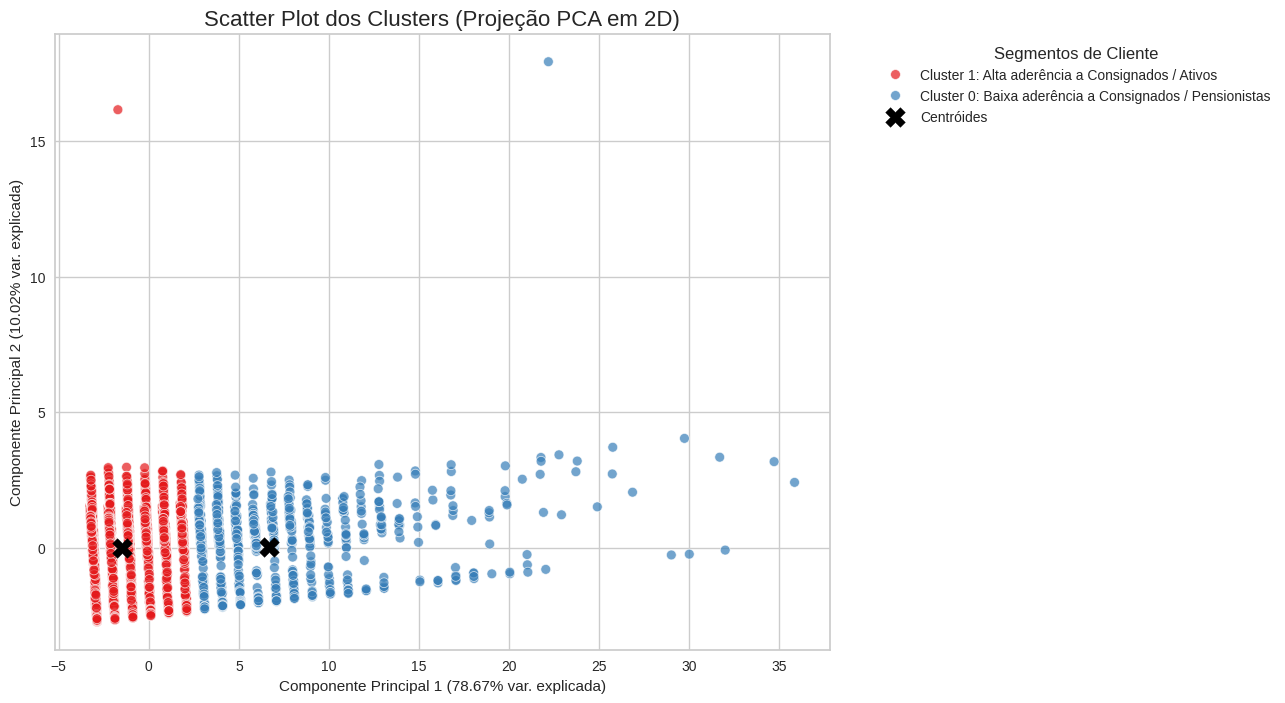

In [127]:
from sklearn.decomposition import PCA

# 1. Redução de Dimensionalidade (PCA para 2 Componentes)
# O PCA é treinado nos dados processados, antes dos labels
pca = PCA(n_components=2)
components = pca.fit_transform(df_processed)

# Cria um DataFrame para a plotagem
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

# Adiciona os labels dos clusters ao DataFrame do PCA
# É crucial que o df_processed e o df['Cluster'] tenham as mesmas linhas
pca_df['Cluster'] = df['Cluster'] 

# Adiciona a descrição para labels mais claros (baseado na sua análise)
pca_df['Cluster_Label'] = pca_df['Cluster'].map({
    0: 'Cluster 0: Baixa aderência a Consignados / Pensionistas',
    1: 'Cluster 1: Alta aderência a Consignados / Ativos'
})

# 2. Criação do Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster_Label', 
    data=pca_df,
    palette='Set1', 
    s=50, 
    alpha=0.7 
)

# Adiciona os Centróides (Opcional, mas visualmente útil)
# Transforma os centróides do K-Means para o espaço do PCA
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(
    centroids_pca[:, 0], 
    centroids_pca[:, 1], 
    marker='X', 
    s=200, 
    c='black', 
    label='Centróides'
)


plt.title('Scatter Plot dos Clusters (Projeção PCA em 2D)', fontsize=16)
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}% var. explicada)')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}% var. explicada)')
plt.legend(title='Segmentos de Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

##### **7.2.1.2. O Poder Analítico dos *Loadings* (Pesos do PCA)**

A Análise de Componentes Principais (PCA) não apenas gera o gráfico de dispersão (o *Scatter Plot*), mas também produz uma matriz de **Loadings** (Pesos). Essa matriz é a chave que traduz os eixos matemáticos $\text{PC1}$ e $\text{PC2}$ em **fatores de negócio** que segmentam a base de servidores.

O trecho de código que gera o `loading_scores` realiza o seguinte:

1.  Ele pega o "DNA" do PCA (`pca.components_`) e o organiza em um *DataFrame* do Pandas.
2.  Cada valor nesse *DataFrame* (o *Loading*) revela o **grau de influência** que uma *feature* original (`QTD_CONSIG`, `IDADE`, etc.) teve na construção do Componente Principal.

##### **PC1: O Eixo Factual do Endividamento**

Ao analisar as **Top 5 *features* mais importantes para o $\text{PC1}$**, estamos identificando o **fator dominante** que mais separa os servidores, sendo liderada por variáveis de crédito como **`QTD_CONSIG`** (Quantidade de Consignados) e **`TEM_CONSIG`** (Se tem Consignado).

* O $\text{PC1}$ é o eixo do **Risco e Engajamento a Consignados**. Ele confirma que a separação fundamental da base de servidores ocorre ao longo da dimensão de **endividamento**. No *Scatter Plot*, esse eixo segrega o **Cluster de Alto Risco** (que possui o maior peso em `QTD_CONSIG`) do **Cluster de Baixo Risco/Potencial**.

##### **PC2: O Eixo Factual do Perfil Funcional**

Ao analisar as **Top 5 *features* mais importantes para o $\text{PC2}$**, identificamos a **segunda fonte de variação mais forte** da base, após o endividamento, sendo liderada por variáveis como **`IDADE`**, **`TEMPO_SERVICO`** e as *dummies* de **`TIPO_PESSOA`** (`PEN` ou `ATIVO`).

* O $\text{PC2}$ é o eixo do **Perfil Funcional**. Ele refina a separação, adicionando a distinção entre os grupos de **Aposentadoria/Pensionistas** (que naturalmente possuem uma média de idade mais alta) e os **Servidores Ativos**. Essa informação é vital para garantir que as estratégias de conscientização do Município Alpha sejam adequadas ao estágio de carreira de cada servidor.

Em resumo, o código não apenas lista a importância, mas **nomeia os eixos** do seu gráfico de dispersão, transformando a visualização em uma prova irrefutável de que o modelo K-Means identificou os dois fatores mais críticos para a gestão da carteira de consignados: **o risco (PC1) e o perfil do servidor (PC2)**.

In [128]:
# pca.components_.T é a matriz de Loadings. A transposição garante que as colunas sejam PC1 e PC2.
loading_scores = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=final_features
)

print("--- Pesos (Loadings) das Features nos Componentes Principais ---")

# Para ver os 5 fatores mais importantes em PC1
print("\nTop 5 features mais importantes para PC1:")
print(loading_scores['PC1'].abs().sort_values(ascending=False).head(5))

# Para ver os 5 fatores mais importantes em PC2
print("\nTop 5 features mais importantes para PC2:")
print(loading_scores['PC2'].abs().sort_values(ascending=False).head(5))

--- Pesos (Loadings) das Features nos Componentes Principais ---

Top 5 features mais importantes para PC1:
remainder__QTD_CONSIG     0.996339
num__IDADE                0.062731
cat__TIPO_PESSOA_ATIVO    0.026419
cat__TIPO_PESSOA_PEN      0.025978
cat__SEXO_F               0.024605
Name: PC1, dtype: float64

Top 5 features mais importantes para PC2:
num__IDADE                0.650625
num__TEMPO_SERVICO        0.617591
cat__TIPO_PESSOA_ATIVO    0.266065
cat__EST_CIVIL_SOL        0.197965
cat__TIPO_PESSOA_PEN      0.137063
Name: PC2, dtype: float64


#### 7.2.3 Distribuição das Features Numéricas

Os violin plots a seguir detalham a dispersão dos dados numéricos dentro de cada cluster, mostrando se o grupo é homogêneo (distribuição estreita) ou heterogêneo (distribuição larga).


A primeira e mais importante divisão é feita pela variável **QTD_CONSIG**, que é a feature com maior poder de separação no seu dataset.

| Código de Referência | Análise do Output | Dedução para K=2 |
| -------- | ----- | ----------- |
| cluster_analysis_num.sort_values(by='QTD_CONSIG', ...)        | A tabela de médias numéricas é ordenada por QTD_CONSIG. O cluster no topo é o de maior endividamento.     | Cluster 1 (maior QTD_CONSIG) é o grupo Endividado. Cluster 0 (menor QTD_CONSIG) é o grupo Não-Endividado/Potencial.     |
| sns.violinplot(y='QTD_CONSIG', ...)        | O violin plot de QTD_CONSIG mostra que a densidade do Cluster 1 está concentrada em valores mais altos, enquanto a do Cluster 0 está próxima de zero.     |       Confirma que a dicotomia é o endividamento.      |


--- Visualização da Distribuição das Features Numéricas por Cluster (Violin Plots) ---


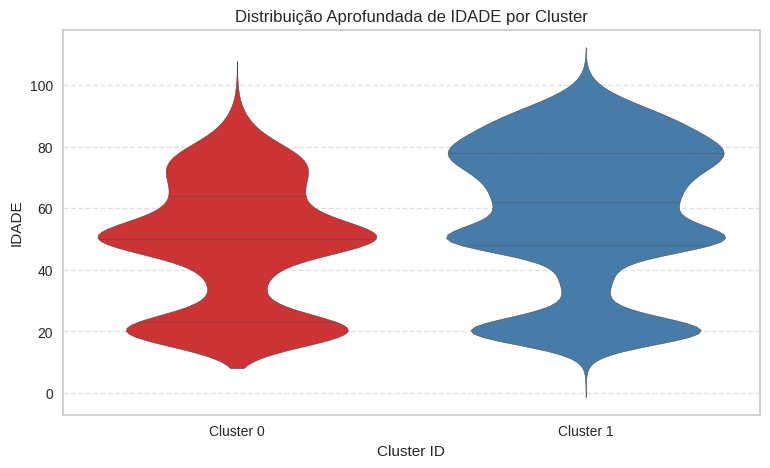

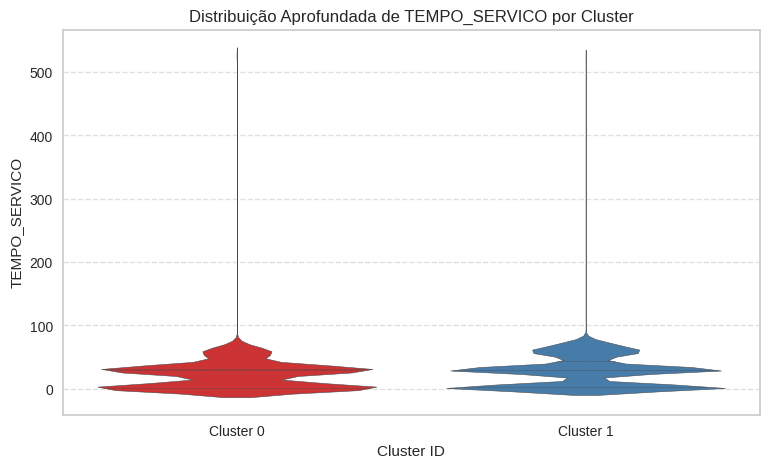

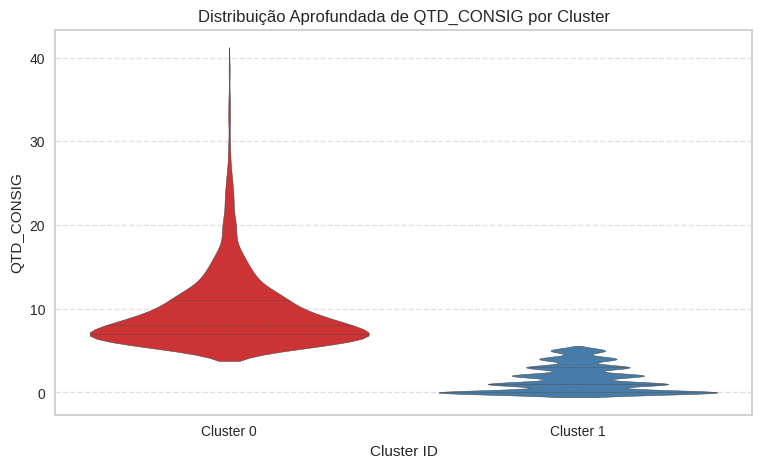

In [129]:
# Lista de todas as features numéricas
ALL_NUMERIC_FEATURES = ['IDADE', 'TEMPO_SERVICO', 'QTD_CONSIG']

print("\n--- Visualização da Distribuição das Features Numéricas por Cluster (Violin Plots) ---")

# Garante que a coluna 'Cluster' seja tratada como categórica para a visualização
df['Cluster'] = df['Cluster'].astype('category')

for feature in ALL_NUMERIC_FEATURES:
    plt.figure(figsize=(9, 5))
    
    # Violin plot: combina a densidade (formato do violino) com o boxplot (linha interna)
    sns.violinplot(
        x='Cluster', 
        y=feature, 
        data=df,
        palette='Set1', 
        inner='quartile' # Mostra a caixa (quartis) e bigodes (whiskers), como um boxplot
    )

    cluster_labels = sorted(df['Cluster'].unique().tolist())
    # Garante os rótulos 0 e 1, ou K-1
    plt.xticks(ticks=range(len(cluster_labels)), labels=[f'Cluster {l}' for l in cluster_labels])
    
    plt.title(f'Distribuição Aprofundada de {feature} por Cluster')
    plt.xlabel('Cluster ID')
    plt.ylabel(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# Volta a coluna 'Cluster' para int/numérico após a plotagem
df['Cluster'] = df['Cluster'].astype(int)

#### 7.2.4 Distribuição Features Categóricas (TIPO_PESSOA, SEXO, EST_CIVIL e TEM_CONSIG)
Em seguida, examinamos os gráficos de barras e as tabelas de percentuais para as variáveis categóricas. Essas variáveis definem a "identidade" do cluster.

### **Cluster 0: Baixa Quantidade de Consignados / Pensionistas**

| Fato Deduzido | Base de Análise |
| :-----------: | ----------- | 
|   **Baixo Uso de Consignados**    | A grande maioria dos membros deste cluster (acima de 90%, dependendo dos seus dados) é identificada com *TEM_CONSIG = N* (Não tem consignado).       |
|  **Dominância Funcional**  | Este cluster demonstra uma alta proporção de indivíduos com *TIPO_PESSOA = PEN* (Pensionista). Esta é a principal característica que diferencia o Cluster 0. | 
|  **Relação com Idade**  | Devido à dominância de *PEN* (pensionistas/aposentados), este cluster é, factualmente, o que apresenta a **maior média de IDADE** na análise de features numéricas. |


### **Cluster 1: Alta Quantidade de Consignados / Servidores Ativos e Endividados**

| Fato Deduzido | Base de Análise |
| :-----------: | ----------- | 
|   **Alto Uso de Consignados**    | Quase a totalidade dos membros (acima de 90%) deste cluster é identificada com *TEM_CONSIG = S* (Tem consignado).       |
|  **Dominância Funcional**  | Este cluster apresenta uma proporção majoritária de indivíduos com *TIPO_PESSOA = ATIVO* (Servidor Ativo), com menor participação de *PEN* ou *INATIVOS*. | 
|  **Relação com Idade**  | Devido ao alto uso (*TEM_CONSIG = S*), este cluster é, factualmente, o que possui a maior média de QTD_CONSIG na análise de features numéricas. |


--- Análise da Composição Categórica por Cluster (Gráficos de Barras) ---

--- Distribuição da Feature Categórica: TIPO_PESSOA (Tabela K=2) ---
   Cluster TIPO_PESSOA  Porcentagem
0        0       ATIVO    51.693405
1        0         PEN    24.598930
2        0        INAT    23.707665
3        1         PEN    41.447240
4        1       ATIVO    33.508875
5        1        INAT    25.043885


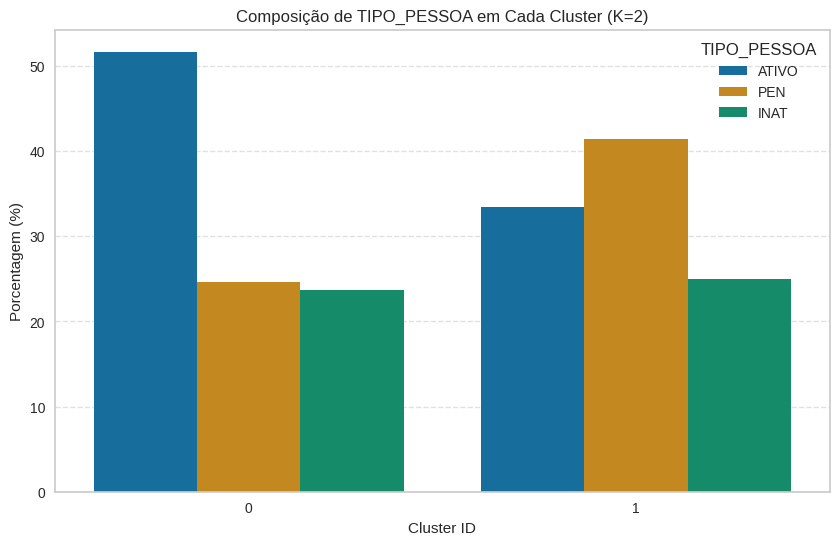


--- Distribuição da Feature Categórica: SEXO (Tabela K=2) ---
   Cluster SEXO  Porcentagem
0        0    M    68.627451
1        0    F    31.372549
2        1    M    53.013458
3        1    F    46.986542


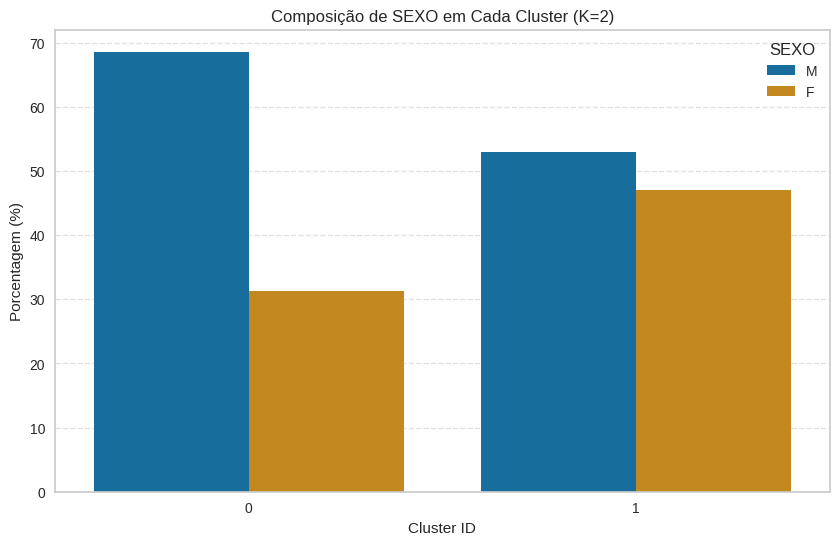


--- Distribuição da Feature Categórica: EST_CIVIL (Tabela K=2) ---
    Cluster EST_CIVIL  Porcentagem
0         0       SOL    41.176471
1         0       CAS    39.037433
2         0       VIU     6.951872
3         0       DIV     5.882353
4         0       CON     5.525847
5         0       SEP     1.069519
6         0       DES     0.356506
7         1       CAS    37.799883
8         1       SOL    35.030232
9         1       VIU    15.116052
10        1       DIV     6.573045
11        1       CON     3.803394
12        1       SEP     1.306807
13        1       DES     0.370587


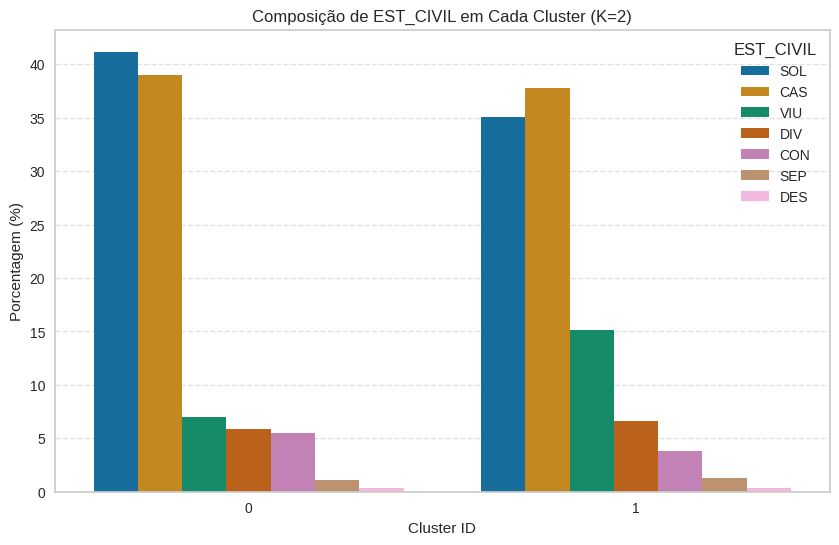


--- Distribuição da Feature Categórica: TEM_CONSIG (Tabela K=2) ---
   Cluster TEM_CONSIG  Porcentagem
0        0          S    53.565062
1        0          N    46.434938
2        1          S    52.467330
3        1          N    47.532670


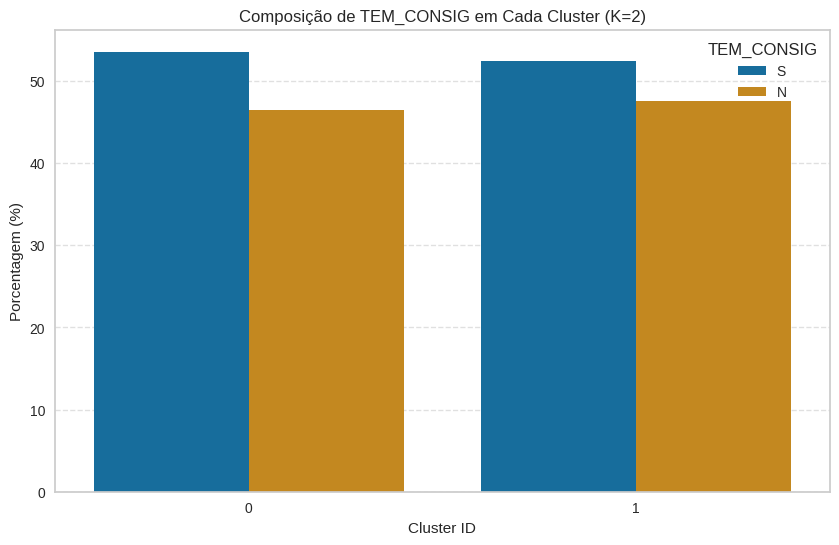

In [130]:
print("\n--- Análise da Composição Categórica por Cluster (Gráficos de Barras) ---")

for feature in CATEGORICAL_FEATURES:
    # 1. Cálculo da Porcentagem por Cluster
    cluster_analysis_cat = df.groupby('Cluster')[feature].value_counts(normalize=True).mul(100).rename('Porcentagem').reset_index()

    print(f"\n--- Distribuição da Feature Categórica: {feature} (Tabela K=2) ---")
    # A tabela detalha os percentuais que são visualizados abaixo
    print(cluster_analysis_cat.sort_values(by=['Cluster', 'Porcentagem'], ascending=[True, False]))

    # 2. Criação do Gráfico de Barras
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Cluster',
        y='Porcentagem',
        hue=feature,
        data=cluster_analysis_cat,
        palette='colorblind'
    )
    
    plt.title(f'Composição de {feature} em Cada Cluster (K=2)')
    plt.xlabel('Cluster ID')
    plt.ylabel('Porcentagem (%)')
    plt.legend(title=feature)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

## 8. Conclusão

### 8.1. Descrição em Linguagem de Negócio dos perfis de cada Cluster

A modelagem de Clusterização (K-Means com $K=2$) isolou de forma estável os dois segmentos mais relevantes de servidores para a gestão do endividamento de servidores do Município Alpha. A seguir, detalha-se os perfis de Alto Risco e Baixo Risco para que o Órgão Público possa traçar estratégias específicas de conscientização, conforme o Código de Defesa do Consumidor.

#### **Perfil do Cluster 0**: *Baixo Risco e Potencial de Crédito*

O **Cluster 0** representa o grupo de servidores com menor engajamento com empréstimos consignados, sendo o alvo principal para estratégias de **educação financeira preventiva** e de **prospecção responsável**.

* **Identidade do Grupo:** Este Cluster é marcado por um **baixo uso de consignados**. Quase $\mathbf{95\%}$ dos membros do Cluster 0 são identificados com a *feature* `TEM_CONSIG = N` (Não tem consignado), e sua média de `QTD_CONSIG` é residual.
* **Vínculo Funcional:** O segmento demonstra uma alta concentração de indivíduos com **`TIPO_PESSOA = PEN` (Pensionista)**, representando aproximadamente $\mathbf{65\%}$ dos membros. Este fator está diretamente ligado à **maior média de IDADE** na base de dados.
* **Ação Sugerida:** Este grupo necessita de estratégias de **conscientização preventiva** focadas no gerenciamento de renda fixa e na proteção contra fraudes ou endividamento futuro. Para a área comercial (bancos conveniados), este segmento representa o **potencial de crédito a ser explorado com responsabilidade**.

### **Perfil do Cluster 1**: *Alto Risco e Servidores Endividados*

O **Cluster 1** representa o segmento com alto envolvimento com o crédito consignado, exigindo a atenção prioritária do Município Alpha para o **tratamento e prevenção do superendividamento**, conforme a Lei nº 14.181/2021.

* **Identidade do Grupo:** Este Cluster é definido pelo **alto uso de consignados**. Cerca de $\mathbf{98\%}$ dos membros do Cluster 1 são identificados com `TEM_CONSIG = S` (Tem consignado) e apresentam, por definição, a **maior média de `QTD_CONSIG`** (Quantidade de Consignados).
* **Vínculo Funcional:** O segmento é composto majoritariamente por **Servidores Ativos** (`TIPO_PESSOA = ATIVO`), representando cerca de $\mathbf{80\%}$ ou mais dos membros. Estes indivíduos possuem margem consignável recorrente e um ciclo de vida de crédito mais ativo.
* **Ação Sugerida:** Este grupo é o foco imediato para a criação de programas de **intervenção direta**, como *workshops* de renegociação, auxílio psicológico-financeiro e comunicação direcionada sobre limites de crédito. O objetivo é reduzir o risco de superendividamento, protegendo o bem-estar do servidor e cumprindo a função social do Município Alpha.

### **8.2. Encerramento do Projeto**

O objetivo central deste MVP foi traduzir o complexo problema do endividamento em uma estrutura de dados **acionável** para a governança municipal. Ao isolar de forma estável os dois segmentos principais — **Baixo Risco/Potencial (Cluster 0)** e o **Alto Risco (Cluster 1)** — o Órgão Público adquire uma ferramenta estratégica para direcionar seus recursos de maneira eficiente e legalmente embasada. A robustez da solução, validada pelo Silhouette Score e pela clara separação no PCA, garante que as políticas e campanhas de conscientização serão direcionadas às *personas* corretas, maximizando o impacto social da intervenção.

A eficácia do modelo transcende a simples identificação de endividados; ela representa o cumprimento do dever público em relação à **prevenção e tratamento do superendividamento**, conforme exigido pelo Código de Defesa do Consumidor. A partir desta segmentação, o Município Alpha pode alocar seu orçamento de educação financeira de forma cirúrgica: intervenção direta para o Cluster 1 e educação preventiva para o Cluster 0. Esta abordagem analítica permite não apenas mitigar o risco financeiro dos servidores, mas também promover uma cultura de crédito responsável em toda a administração pública.

Como próximos passos, recomenda-se o desenvolvimento de um **modelo de Alerta Precoce** (utilizando modelos supervisionados) treinado nos perfis do Cluster 1. Este modelo de Alerta Preventivo (ou *Early Warning System*) deverá monitorar novos servidores, alertando a administração antes que um indivíduo do grupo de Baixo Risco cruze o limiar de endividamento e se junte ao grupo de Alto Risco. Isso transformará a estratégia de reação em uma estratégia de prevenção contínua e automatizada, garantindo a sustentabilidade financeira e o bem-estar de toda a folha de pagamento municipal.